<a href="https://colab.research.google.com/github/shonyeajin/KCBD/blob/main/RNN%EA%B3%A0%EA%B8%89%EC%82%AC%EC%9A%A9%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir jena_climate

In [2]:
!cd jena_climate

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-01-11 04:28:01--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  36.0MB/s    in 0.4s    

2022-01-11 04:28:01 (36.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [4]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [5]:
import os

data_dir='./datasets/jena_climate'
fname=os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f=open(fname)
data=f.read()
f.close()

In [6]:
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

In [10]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [12]:
print(lines[1])

01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


In [11]:
import numpy as np

float_data=np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
  values=[float(x) for x in line.split(',')[1:]]
  float_data[i,:]=values

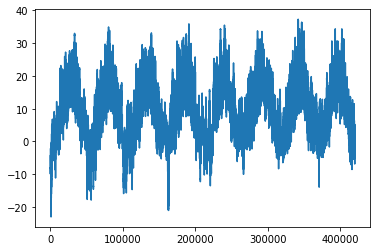

In [13]:
from matplotlib import pyplot as plt

temp=float_data[:,1]
plt.plot(range(len(temp)),temp)

위는 섭씨온도로 그린 그래프

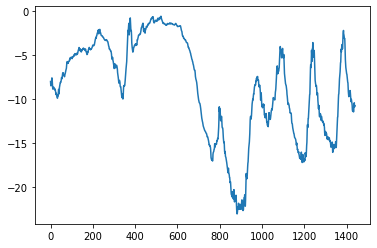

In [14]:
plt.plot(range(1440),temp[:1440])

위는 10일 마다의 섭씨온도 그래프

In [15]:
mean=float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std

In [33]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index=len(data)-delay-1
  i=min_index+lookback
  while 1:
    if shuffle:
      rows=np.random.randint(min_index +lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i= min_index + lookback
      rows=np.arange(i,min(i+batch_size, max_index))
      i+=len(rows)

    samples=np.zeros((len(rows),lookback //step, data.shape[-1]))
    targets=np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices=range(rows[j]- lookback, rows[j], step)
      samples[j]=data[indices]
      targets[j]=data[rows[j]+delay][1]
    yield samples, targets


In [34]:
lookback=1440
step=6
delay=144
batch_size=128

train_gen=generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
val_gen=generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen=generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps=(300000-200001-lookback) // batch_size

test_steps=(len(float_data)-300001-lookback)//batch_size

상식수준의 기준점

In [35]:
def evaluate_naive_method():
  batch_maes=[]
  for step in range(val_steps):
    samples,targets=next(val_gen)
    preds=samples[:,-1,1]
    mae=np.mean(np.abs(preds-targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [36]:
0.29 * std[1]

2.5672247338393395

기본적인 머신러닝 방법

In [37]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 18s 36ms/step - loss: 1.8301 - val_loss: 0.9280
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.6335 - val_loss: 0.3187
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3036 - val_loss: 0.3224
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2740 - val_loss: 0.3320
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2563 - val_loss: 0.3315
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2468 - val_loss: 0.3133
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2385 - val_loss: 0.3105
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2320 - val_loss: 0.3589
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2263 - val_loss: 0.3511
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2219 - val_los

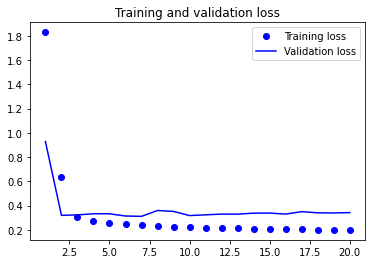

In [38]:
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

RNN 적용해보기

In [43]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
500/500 [==============================] - 36s 65ms/step - loss: 0.3000 - val_loss: 0.2681
Epoch 2/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2803 - val_loss: 0.2683
Epoch 3/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2777 - val_loss: 0.2614
Epoch 4/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2714 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2674 - val_loss: 0.2610
Epoch 6/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2646 - val_loss: 0.2596
Epoch 7/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2591 - val_loss: 0.2621
Epoch 8/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2543 - val_loss: 0.2641
Epoch 9/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2495 - val_loss: 0.2630
Epoch 10/20
500/500 [==============================] - 33s 65ms/step - loss: 0.246

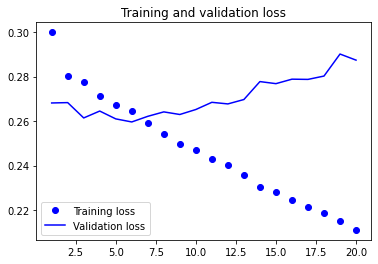

In [44]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(layers.GRU(32, dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/40
281/500 [===============>..............] - ETA: 4:26 - loss: 0.3345

KeyboardInterrupt: ignored

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/40


KeyboardInterrupt: ignored

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

양방향 RNN 사용하기

In [50]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None,float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/40
 36/500 [=>............................] - ETA: 39s - loss: 0.3486

KeyboardInterrupt: ignored